## 数据分析

In [1]:
# 导入第三方库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

In [2]:
data = pd.read_excel("Concrete_Data.xls")

In [3]:
# 给数据集的列名重新改名
req_col_names = ["Cement", "BlastFurnaceSlag", "FlyAsh", "Water", "Superplasticizer",
                 "CoarseAggregate", "FineAggregate", "Age", "CC_Strength"]
curr_col_names = list(data.columns)

In [4]:
mapper = {}
for i, name in enumerate(curr_col_names):
    mapper[name] = req_col_names[i]

data = data.rename(columns=mapper)

In [5]:
data.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CC_Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [6]:
# describe()函数就是返回data数据结构的统计变量。
# 其目的在于观察这一系列数据的范围、大小、波动趋势等等，为后面的模型选择打下基础。
data.describe()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CC_Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


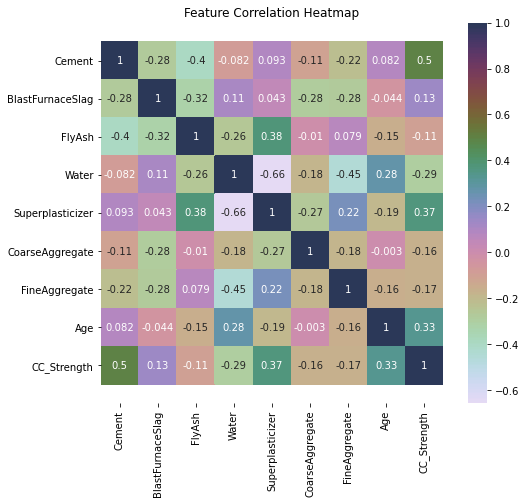

In [7]:
corr = data.corr()
plt.figure(figsize=(9,7))
cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(corr, annot=True,square=True,cmap=cmap)
b, t = plt.ylim()
plt.ylim(b+0.5, t-0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

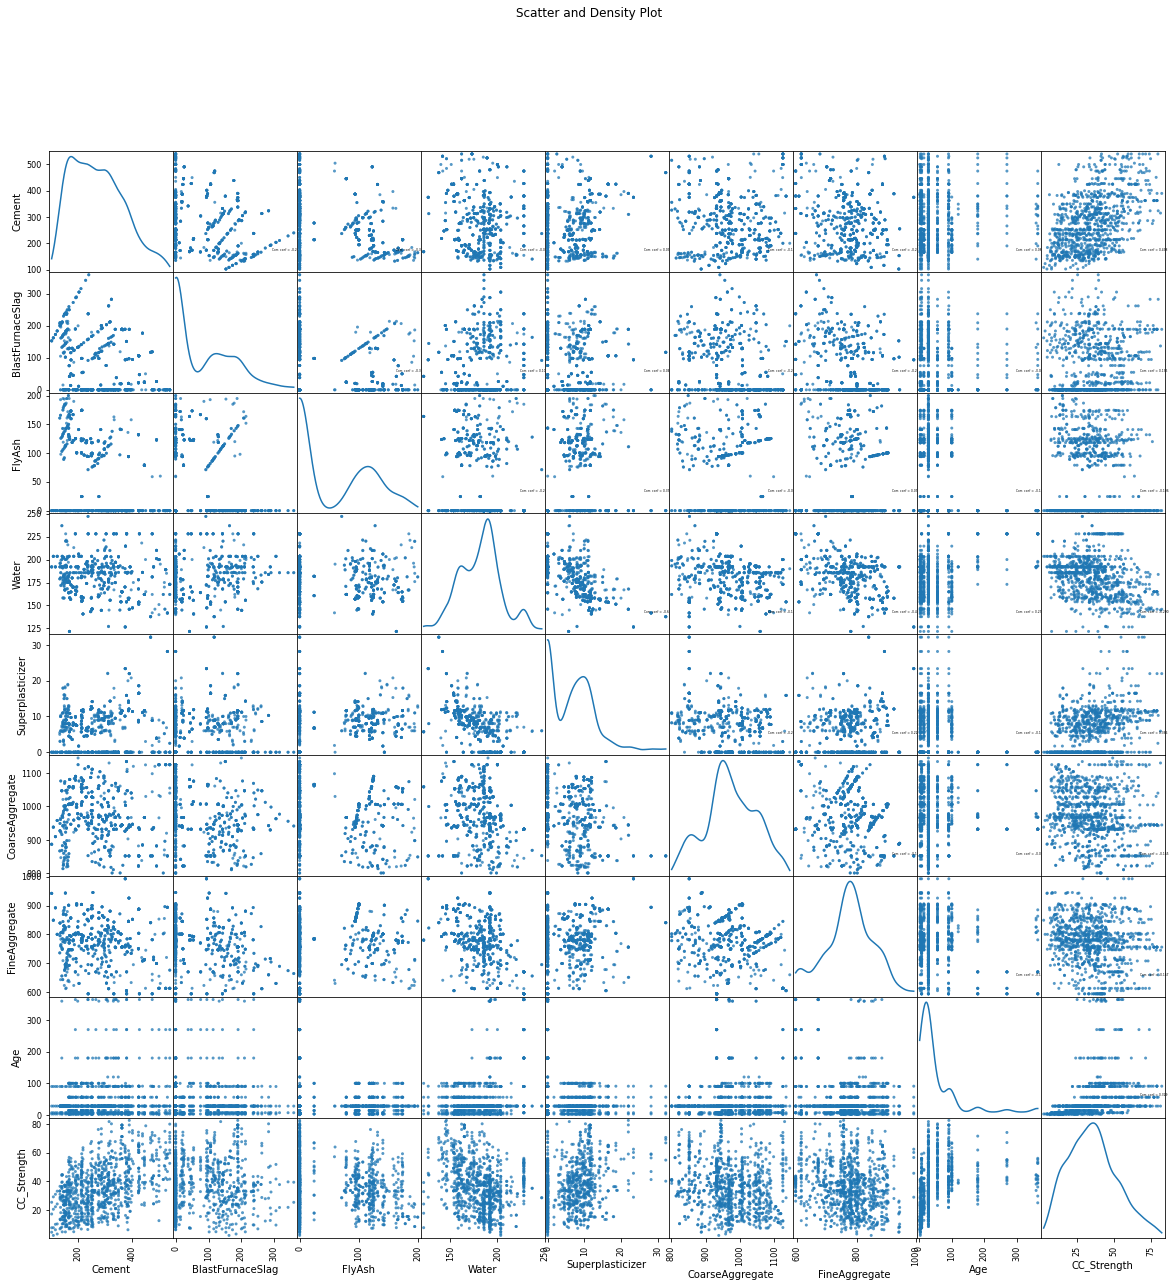

In [8]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='left', va='top', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
    
plotScatterMatrix(data, 20, 3)

D:\softwares\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Compressive Strength Distribution')

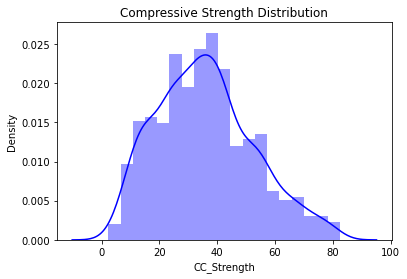

In [9]:
# 对因变量CC_Strength做分布图，大致符合正态分布。
ax = sns.distplot(data.CC_Strength,color="b")
ax.set_title("Compressive Strength Distribution")

In [10]:
# 区分自变量和因变量，将前面所有的作为自变量，最后一个作为回归的因变量。
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

In [11]:
# 标准归一化，将特征表现为标准正态分布数据(均值为0，方差为1)。
# 如果某个特征的方差比其他特征大几个数量级，那么它就会在学习算法中占据主导位置，导致学习器不能从其他特征中学习，从而降低精度。
# 进行归一化可以加快梯度下降求解的速度。
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 模型搭建

In [12]:
# Importing models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

# 线性回归
lr = LinearRegression()
# 最小角回归
lasso = Lasso()
# 岭回归
ridge = Ridge()
# SVM回归
SVM = svm.SVR()
# KNN回归
KNN = neighbors.KNeighborsRegressor()
# Adaboost回归
Ada = AdaBoostRegressor(n_estimators=100)#这里使用100个决策树
# 决策树回归
dtr = DecisionTreeRegressor()
# 随机森林回归
rfr = RandomForestRegressor(n_estimators=100)
# GBRT回归
GBRT = GradientBoostingRegressor(n_estimators=100)
# Bagging
BR = BaggingRegressor()
# ExtraTree极端随机树回归
ETR = ExtraTreeRegressor()
    
# Fitting models on Training data
# 模型训练
lr.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
SVM.fit(X_train, y_train)
KNN.fit(X_train, y_train)
Ada.fit(X_train, y_train)
dtr.fit(X_train, y_train)
rfr.fit(X_train, y_train)
GBRT.fit(X_train, y_train)
BR.fit(X_train, y_train)
ETR.fit(X_train, y_train)

# Making predictions on Test data
y_pred_lr = lr.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_SVM = SVM.predict(X_test)
y_pred_KNN = KNN.predict(X_test)
y_pred_Ada = Ada.predict(X_test)
y_pred_dtr = dtr.predict(X_test)
y_pred_rfr = rfr.predict(X_test)
y_pred_GBRT = GBRT.predict(X_test)
y_pred_BR = BR.predict(X_test)
y_pred_ETR = ETR.predict(X_test)

## 结果展示

In [13]:
print("Model\t RMSE \t MSE \t MAE \t R2")
print("""LinearRegression \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_lr)),mean_squared_error(y_test, y_pred_lr),
            mean_absolute_error(y_test, y_pred_lr), r2_score(y_test, y_pred_lr)))
print("""LassoRegression \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_lasso)),mean_squared_error(y_test, y_pred_lasso),
            mean_absolute_error(y_test, y_pred_lasso), r2_score(y_test, y_pred_lasso)))
print("""RidgeRegression \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_ridge)),mean_squared_error(y_test, y_pred_ridge),
            mean_absolute_error(y_test, y_pred_ridge), r2_score(y_test, y_pred_ridge)))
print("""SVM-Regression \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_SVM)),mean_squared_error(y_test, y_pred_SVM),
            mean_absolute_error(y_test, y_pred_SVM), r2_score(y_test, y_pred_SVM)))
print("""KNN-Regression \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_KNN)),mean_squared_error(y_test, y_pred_KNN),
            mean_absolute_error(y_test, y_pred_KNN), r2_score(y_test, y_pred_KNN)))
print("""AdaBoost Regressor \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_Ada)),mean_squared_error(y_test, y_pred_Ada),
            mean_absolute_error(y_test, y_pred_Ada), r2_score(y_test, y_pred_Ada)))
print("""DecisionTreeRegressor \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_dtr)),mean_squared_error(y_test, y_pred_dtr),
            mean_absolute_error(y_test, y_pred_dtr), r2_score(y_test, y_pred_dtr)))
print("""RandomForestRegressor \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_rfr)),mean_squared_error(y_test, y_pred_rfr),
            mean_absolute_error(y_test, y_pred_rfr), r2_score(y_test, y_pred_rfr)))
print("""GBRTRegressor \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_GBRT)),mean_squared_error(y_test, y_pred_GBRT),
            mean_absolute_error(y_test, y_pred_GBRT), r2_score(y_test, y_pred_GBRT)))
print("""BaggingRegressor \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_BR)),mean_squared_error(y_test, y_pred_BR),
            mean_absolute_error(y_test, y_pred_BR), r2_score(y_test, y_pred_BR)))
print("""ExtraTreeRegressor \t {:.2f} \t {:.2f} \t{:.2f} \t{:.6f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_ETR)),mean_squared_error(y_test, y_pred_ETR),
            mean_absolute_error(y_test, y_pred_ETR), r2_score(y_test, y_pred_ETR)))

Model	 RMSE 	 MSE 	 MAE 	 R2
LinearRegression 	 11.17 	 124.81 	8.79 	0.548376
LassoRegression 	 11.97 	 143.22 	9.56 	0.481768
RidgeRegression 	 11.17 	 124.85 	8.80 	0.548220
SVM-Regression 	 10.27 	 105.39 	8.05 	0.618657
KNN-Regression 	 9.55 	 91.14 	7.52 	0.670206
AdaBoost Regressor 	 7.74 	 59.97 	6.31 	0.783016
DecisionTreeRegressor 	 7.04 	 49.63 	4.61 	0.820418
RandomForestRegressor 	 5.30 	 28.11 	3.71 	0.898280
GBRTRegressor 	 5.36 	 28.69 	3.89 	0.896172
BaggingRegressor 	 5.66 	 32.03 	3.96 	0.884082
ExtraTreeRegressor 	 8.19 	 67.09 	5.32 	0.757248
